# Imports & Settings

In [1]:
# python = 3.10.14
# anndata = 0.10.7
# squidpy = 1.4.1
# scanpy = 1.10.1
# spatialleiden = 0.2.0

import warnings

import anndata as ad
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import spatialleiden as sl
import squidpy as sq

filepath = "spat_reseg5.h5ad"

In [2]:
ID_conversion = {
    "bc.bc": "BALB/c to BALB/c 1",
    "bl6.bl6": "C57BL/6 to C57BL/6 1",
    "bc.bl6.1": "BALB/c to C57BL/6 1",
    "bc.bl6.3": "BALB/c to C57BL/6 3",
    "bl6.bc.1": "C57BL/6 to BALB/c 1",
    "bl6.bc.2": "C57BL/6 to BALB/c 2",
    "bl6.bc.3": "C57BL/6 to BALB/c 3",
}

ID_colors = {
    "BALB/c to BALB/c 1": "#B3B3B3",
    "C57BL/6 to C57BL/6 1": "#4D4D4D",
    "BALB/c to C57BL/6 1": "#BCEE68",
    "BALB/c to C57BL/6 3": "#A2CD5A",
    "C57BL/6 to BALB/c 1": "#9AC0CD",
    "C57BL/6 to BALB/c 2": "#68838B",
    "C57BL/6 to BALB/c 3": "#ADD8E6",
}

In [3]:
def fraction_of_labels(df, batch, label):
    df = df.groupby([batch, label], observed=False).size().to_frame("n").reset_index()
    df["fraction"] = df["n"] / df.groupby(batch, observed=False)["n"].transform("sum")
    return df


def stacked_barplot(ax, data, x, y, hue, palette, legend=False):
    bottoms = np.zeros(data[x].nunique())
    x_max = data[x].max() + 0.5
    x_min = data[x].min() - 0.5

    for c, df in data.groupby(hue, observed=False):
        ax.bar(df[x], df[y], 1, label=c, bottom=bottoms, color=palette[c])
        bottoms += df[y].to_numpy()

    ax.set(ylim=(0, 1), xlim=(x_min, x_max), xlabel=x, ylabel=y)
    if legend:
        n = data[hue].nunique()
        ax.legend(
            loc="center left", bbox_to_anchor=(1, 0.5), title=hue, ncols=-(n // -20)
        )

# Prepare data

In [4]:
adata = ad.read_h5ad(filepath)

# flip y-axis for plotting consistency
adata.obsm["spatial"][:, 1] *= -1

# merge CD8+ T-cells
celltype_mapping = {ct: ct for ct in adata.obs["celltype_level_2"].cat.categories}
celltype_mapping["Cd8+ T cells_2_prolif"] = "Cd8+ T cells"
# celltype_mapping["NA"] = None

adata.obs = adata.obs.assign(
    celltype_level_2=lambda df: df["celltype_level_2"]
    .map(celltype_mapping)
    .astype("category")
)

# rename samples
adata.obs["sample"] = pd.Categorical(
    adata.obs["sample"].map(ID_conversion), categories=ID_conversion.values()
)

# Neighbor definition and Domain clustering

In [5]:
sq.gr.spatial_neighbors(adata, coord_type="generic", n_neighs=10, library_key="sample")

adata.obsp["spatial_connectivities"] = sl.distance2connectivity(
    adata.obsp["spatial_distances"]
)

In [6]:
sc.pp.neighbors(adata, use_rep="X_harmony", random_state=42)

/dh-projects/ag-ishaque/analysis/muellni/envs/spatialleiden/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
sl.spatialleiden(
    adata,
    resolution=(0.9, 0.9),
    directed=(False, True),
    layer_ratio=1.1,
    n_iterations=10,
    seed=42,
)

adata.obs[["spatialleiden"]].to_csv("SpatialLeiden.tsv", sep="\t")

IOStream.flush timed out
IOStream.flush timed out


## Plotting

In [5]:
adata.obs = adata.obs.join(pd.read_csv("SpatialLeiden.tsv", sep="\t", index_col=0))

In [6]:
adata.obs["spatialleiden"].value_counts()

spatialleiden
0    300081
1    274707
2    222695
3    221071
4    151250
5    148325
6    125694
7     89171
8     39173
9      7980
Name: count, dtype: int64

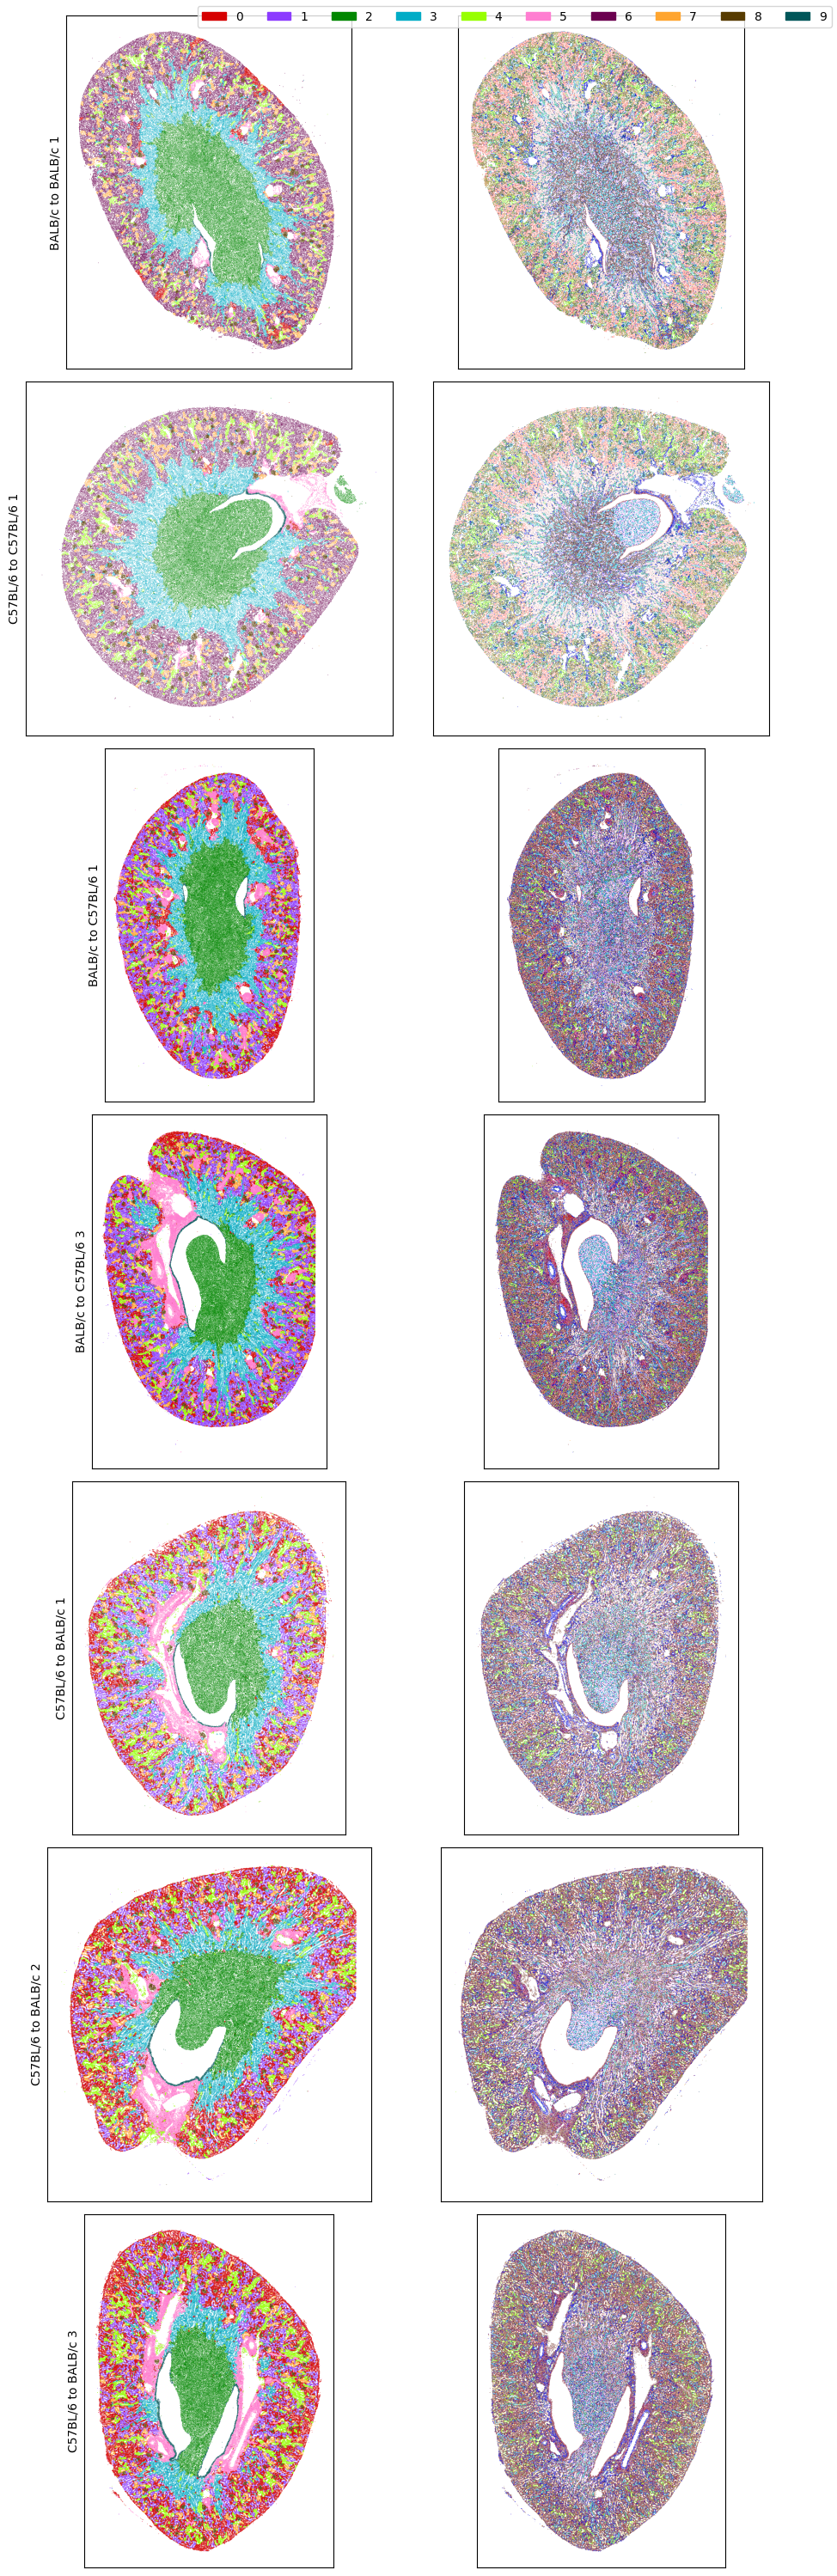

In [11]:
data = adata.obs[["sample", "spatialleiden", "celltype_level_2"]]
data.loc[:, ["x", "y"]] = adata.obsm["spatial"]

key = "spatialleiden"

from matplotlib.patches import Patch

n_domains = data[key].nunique()

fig, axs = plt.subplots(7, 2, figsize=(10, 30))

scatter_kwargs = dict(x="x", y="y", lw=0, s=0.2, palette=cc.glasbey, legend=False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, (s, df) in enumerate(data.groupby("sample", observed=True)):
        sns.scatterplot(data=df, hue=key, ax=axs[i, 0], **scatter_kwargs)
        sns.scatterplot(data=df, hue="celltype_level_2", ax=axs[i, 1], **scatter_kwargs)
        axs[i, 0].set_ylabel(s)
        axs[i, 1].set_ylabel(None)

for ax in axs.ravel():
    ax.set(aspect="equal", xlabel=None, xticks=[], yticks=[])


fig.legend(
    handles=[Patch(color=c, label=i) for i, c in enumerate(cc.glasbey[:n_domains])],
    ncol=10,
)

fig.tight_layout()

In [18]:
# legend_only
fig = plt.figure(figsize=(10, 2))
fig.legend(
    handles=[Patch(color=c, label=i) for i, c in enumerate(cc.glasbey[:n_domains])],
    ncol=10,
    frameon=False,
    loc="center",
)
fig.savefig("legend_sl.png", dpi=300)
fig.savefig("legend_sl.svg")

<Figure size 1000x200 with 0 Axes>

/tmp/ipykernel_787185/794401961.py:9: UserWarning: The palette list has more values (256) than needed (10), which may not be intended.
  sns.scatterplot(data=df, hue=key, ax=ax, **scatter_kwargs)


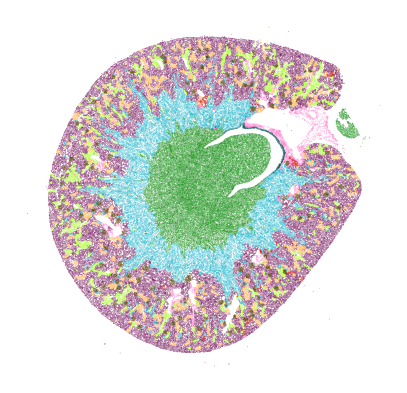

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=data.loc[lambda df: df["sample"] == "C57BL/6 to C57BL/6 1"],
    hue=key,
    ax=ax,
    **scatter_kwargs
)
ax.set(aspect="equal", xlabel=None, ylabel=None, xticks=[], yticks=[])
ax.set_axis_off()
fig.savefig("c57bl6_control.png", dpi=600)

/tmp/ipykernel_787185/755794297.py:9: UserWarning: The palette list has more values (256) than needed (10), which may not be intended.
  sns.scatterplot(data=df, hue=key, ax=ax, **scatter_kwargs)


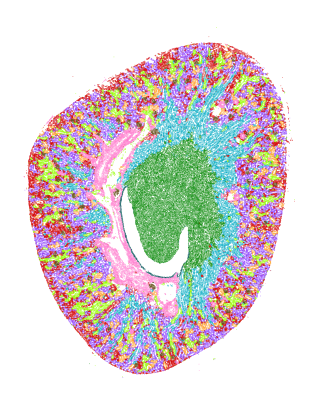

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=data.loc[lambda df: df["sample"] == "C57BL/6 to BALB/c 1"],
    hue=key,
    ax=ax,
    **scatter_kwargs
)
ax.set(aspect="equal", xlabel=None, ylabel=None, xticks=[], yticks=[])
ax.set_axis_off()
fig.savefig("c57bl6_balbc.png", dpi=600)

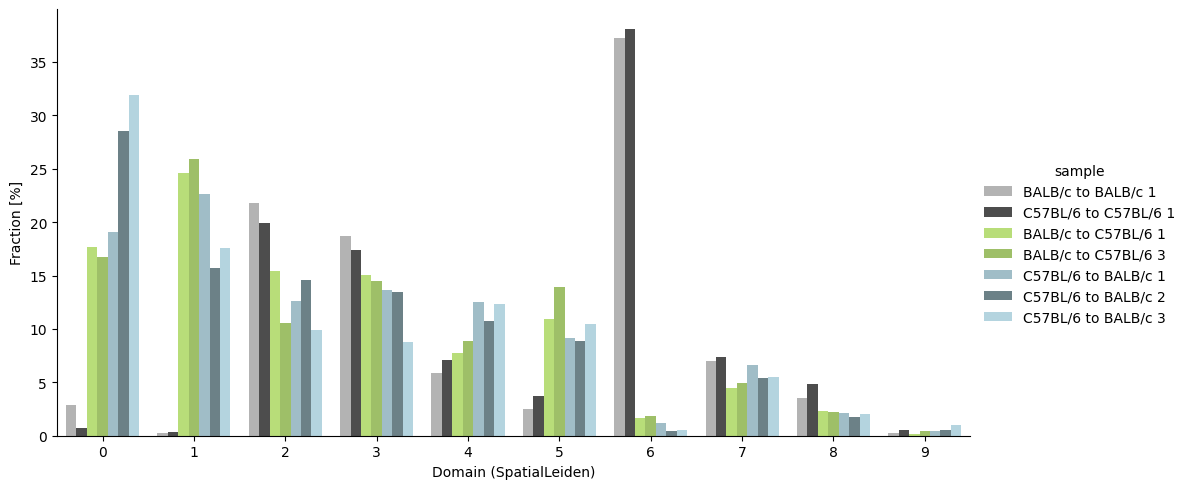

In [11]:
# Compare domain distribution across samples
batch = "sample"
anno = "spatialleiden"

frac = fraction_of_labels(
    adata.obs[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fg = sns.catplot(
    data=frac.assign(fraction=frac["fraction"] * 100),
    kind="bar",
    x=anno,
    y="fraction",
    hue=batch,
    aspect=2,
    palette=ID_colors,
)
_ = fg.set_ylabels("Fraction [%]")
_ = fg.set_xlabels("Domain (SpatialLeiden)")

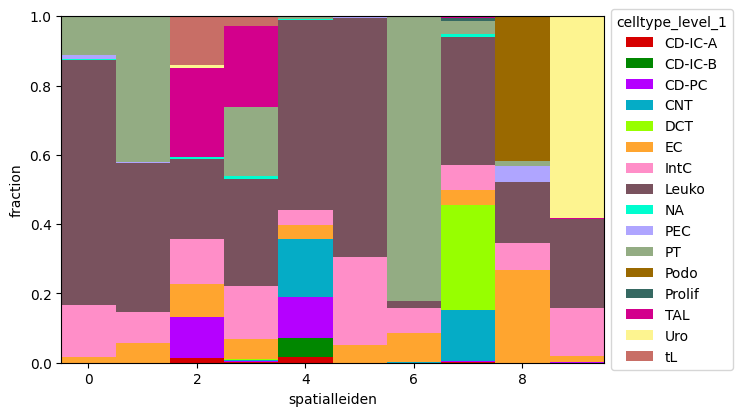

In [12]:
batch = "spatialleiden"
anno = "celltype_level_1"

data = adata.obs

frac = fraction_of_labels(
    data[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fig, ax = plt.subplots(figsize=(7, 4.5))
stacked_barplot(
    ax,
    frac,
    batch,
    "fraction",
    hue=anno,
    palette=dict(zip(data[anno].cat.categories, cc.glasbey_light)),
    legend=True,
)

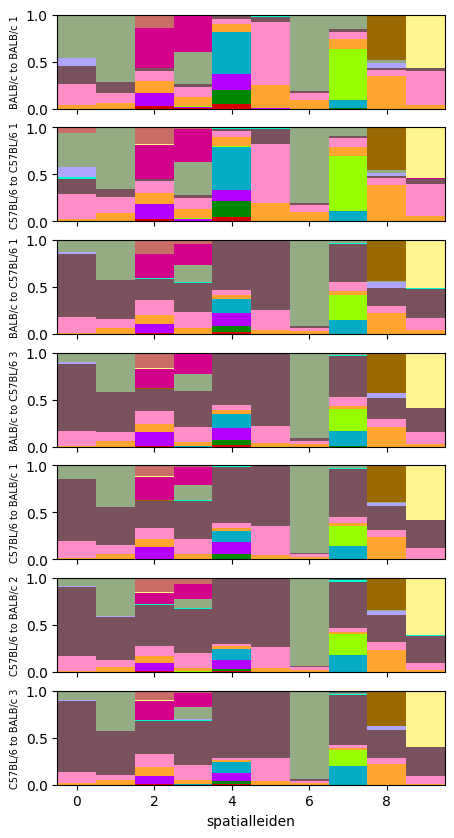

In [13]:
batch = "spatialleiden"
anno = "celltype_level_1"

data = adata.obs

n_samples = data["sample"].nunique()

fig, axs = plt.subplots(n_samples, figsize=(5, 10), sharex=True, sharey=True)

for i, (s, df) in enumerate(data.groupby("sample", observed=True)):
    frac = fraction_of_labels(
        df[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
        batch,
        anno,
    )

    stacked_barplot(
        axs[i],
        frac,
        batch,
        "fraction",
        hue=anno,
        palette=dict(zip(df[anno].cat.categories, cc.glasbey_light)),
        legend=False,
    )
    axs[i].set_ylabel(s, size=7)
    if i != (n_samples - 1):
        axs[i].set(xlabel=None)

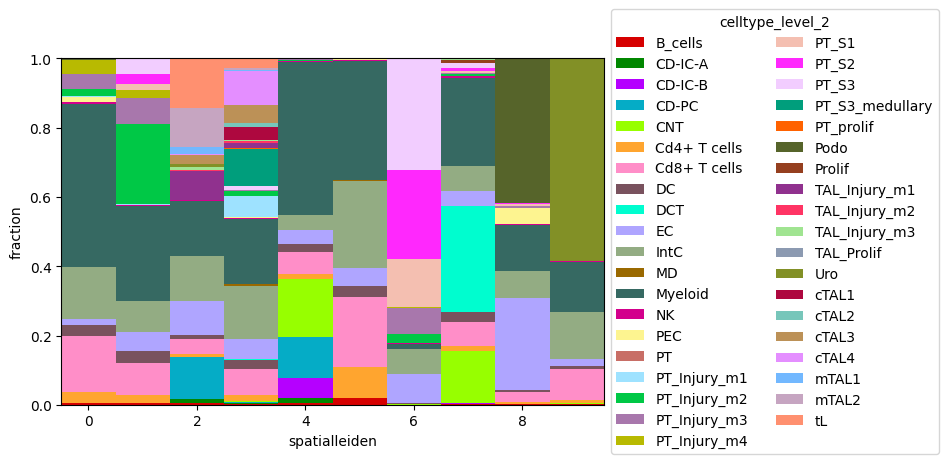

In [14]:
batch = "spatialleiden"
anno = "celltype_level_2"

data = adata.obs

frac = fraction_of_labels(
    data[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fig, ax = plt.subplots(figsize=(7, 4.5))
stacked_barplot(
    ax,
    frac,
    batch,
    "fraction",
    hue=anno,
    palette=dict(zip(data[anno].cat.categories, cc.glasbey_light)),
    legend=True,
)

# Subclustering

### TAL

In [27]:
key = "spatialleiden_tal"

In [15]:
subset = adata[adata.obs["spatialleiden"] == 2].copy()

In [16]:
sc.pp.neighbors(subset, use_rep="X_harmony", random_state=42)

In [17]:
subset.write_h5ad("tal.h5ad")

In [ ]:
sl.spatialleiden(
    subset,
    resolution=(0.4, 0.8),
    directed=(False, True),
    layer_ratio=1.1,
    n_iterations=10,
    key_added=key,
    seed=42,
)

subset.obs[[key]].to_csv("SpatialLeiden_TAL.tsv", sep="\t")

#### Plotting

In [26]:
subset = ad.read_h5ad("tal.h5ad")

subset.obs = subset.obs.join(
    pd.read_csv("SpatialLeiden_TAL.tsv", sep="\t", index_col=0)
)

In [28]:
subset.obs[key].value_counts()

spatialleiden_tal
0    79413
1    70461
2    40654
3    24397
4     7770
Name: count, dtype: int64

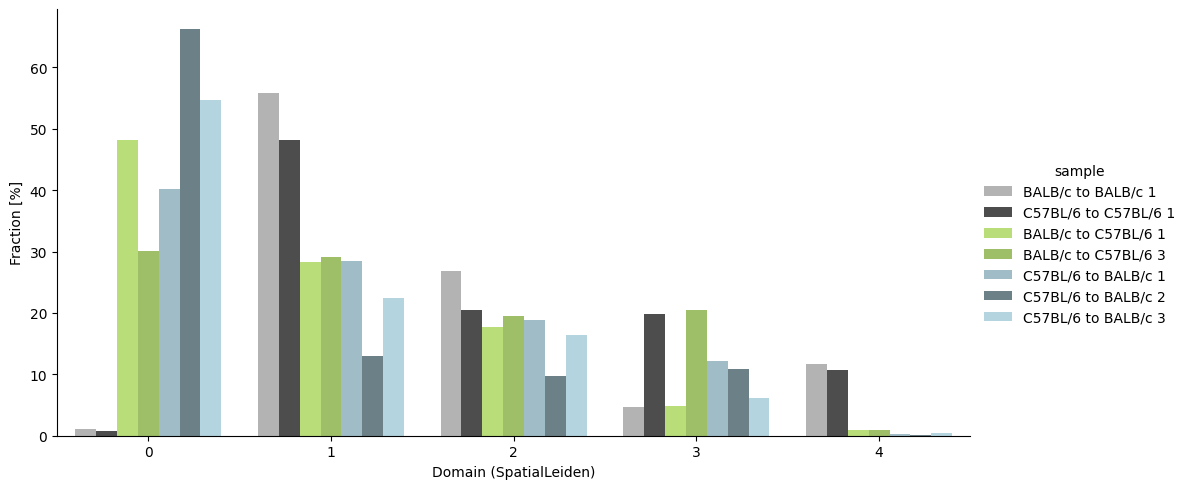

In [20]:
batch = "sample"
anno = key

frac = fraction_of_labels(
    subset.obs[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fg = sns.catplot(
    data=frac.assign(fraction=frac["fraction"] * 100),
    kind="bar",
    x=anno,
    y="fraction",
    hue=batch,
    aspect=2,
    palette=ID_colors,
)
_ = fg.set_ylabels("Fraction [%]")
_ = fg.set_xlabels("Domain (SpatialLeiden)")

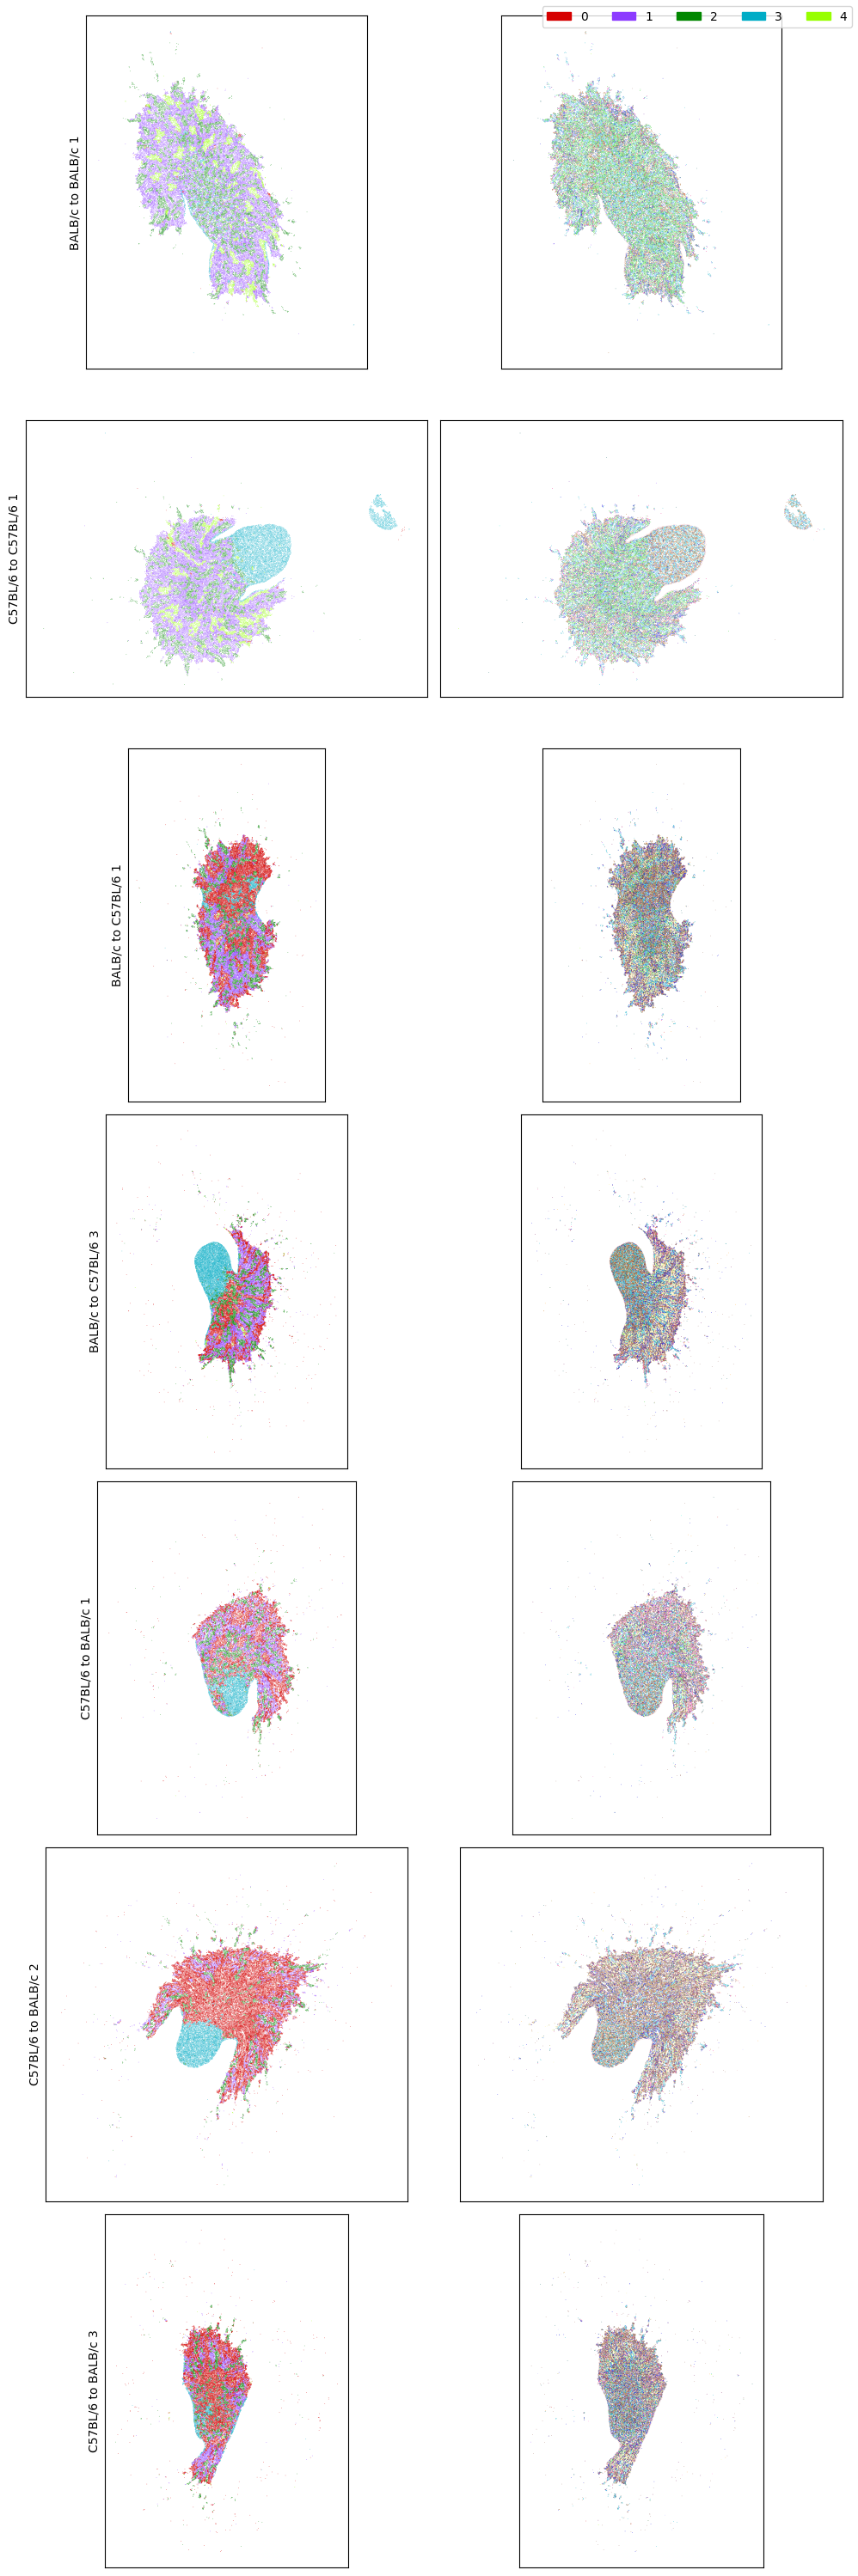

In [23]:
data = subset.obs[["sample", key, "celltype_level_2"]]
data.loc[:, ["x", "y"]] = subset.obsm["spatial"]


from matplotlib.patches import Patch

n_domains = data[key].nunique()

fig, axs = plt.subplots(7, 2, figsize=(10, 30))

scatter_kwargs = dict(x="x", y="y", lw=0, s=0.2, palette=cc.glasbey, legend=False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, (s, df) in enumerate(data.groupby("sample", observed=True)):
        sns.scatterplot(data=df, hue=key, ax=axs[i, 0], **scatter_kwargs)
        sns.scatterplot(data=df, hue="celltype_level_2", ax=axs[i, 1], **scatter_kwargs)
        axs[i, 0].set_ylabel(s)
        axs[i, 1].set_ylabel(None)

for ax in axs.ravel():
    ax.set(aspect="equal", xlabel=None, xticks=[], yticks=[])


fig.legend(
    handles=[Patch(color=c, label=i) for i, c in enumerate(cc.glasbey[:n_domains])],
    ncol=10,
)

fig.tight_layout()

In [24]:
# legend_only
fig = plt.figure(figsize=(10, 2))
fig.legend(
    handles=[Patch(color=c, label=i) for i, c in enumerate(cc.glasbey[:n_domains])],
    ncol=10,
    frameon=False,
    loc="center",
)
fig.savefig("legend_sl_tal.png", dpi=300)
fig.savefig("legend_sl_tal.svg")

<Figure size 1000x200 with 0 Axes>

In [29]:
data = subset.obs[["sample", key, "celltype_level_2"]]
data.loc[:, ["x", "y"]] = subset.obsm["spatial"]

/tmp/ipykernel_787185/3163649377.py:3: UserWarning: The palette list has more values (256) than needed (5), which may not be intended.
  sns.scatterplot(


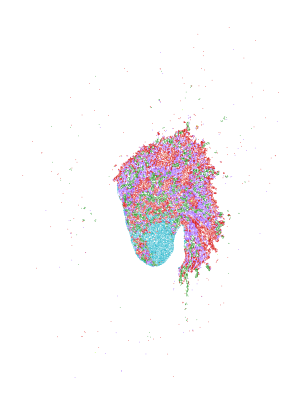

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=data.loc[lambda df: df["sample"] == "C57BL/6 to BALB/c 1"],
    hue=key,
    ax=ax,
    **scatter_kwargs
)
ax.set(aspect="equal", xlabel=None, ylabel=None, xticks=[], yticks=[])
ax.set_axis_off()
fig.savefig("c57bl6_balbc_tal.png", dpi=600)

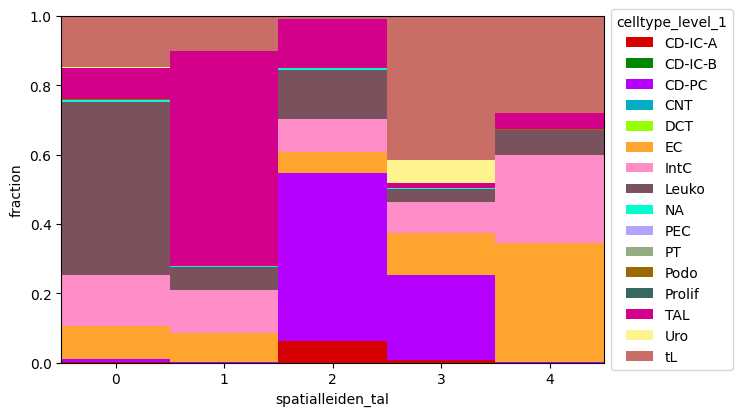

In [23]:
batch = key
anno = "celltype_level_1"

data = subset.obs

frac = fraction_of_labels(
    data[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fig, ax = plt.subplots(figsize=(7, 4.5))
stacked_barplot(
    ax,
    frac,
    batch,
    "fraction",
    hue=anno,
    palette=dict(zip(data[anno].cat.categories, cc.glasbey_light)),
    legend=True,
)

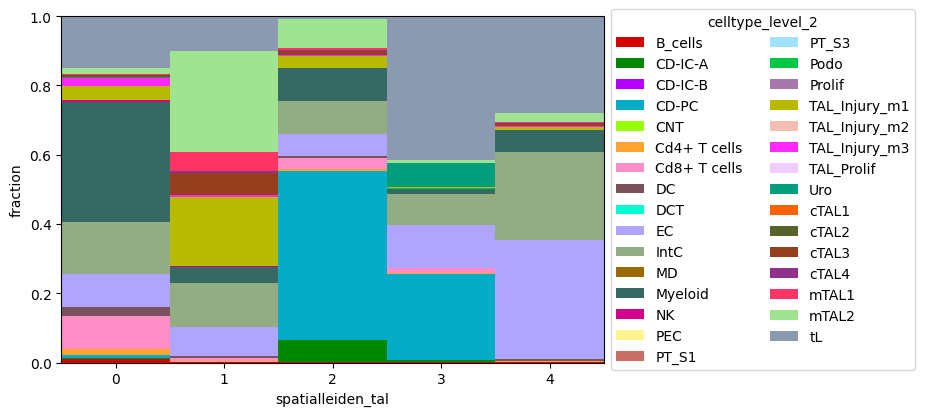

In [24]:
batch = key
anno = "celltype_level_2"

data = subset.obs

frac = fraction_of_labels(
    data[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fig, ax = plt.subplots(figsize=(7, 4.5))
stacked_barplot(
    ax,
    frac,
    batch,
    "fraction",
    hue=anno,
    palette=dict(zip(data[anno].cat.categories, cc.glasbey_light)),
    legend=True,
)

### PT

In [31]:
key = "spatialleiden_pt"

In [25]:
# subset = adata[adata.obs["spatialleiden"].isin([0, 1])].copy()
subset = adata[adata.obs["spatialleiden"].isin([0, 1, 6])].copy()

In [26]:
sc.pp.neighbors(subset, use_rep="X_harmony", random_state=42)

In [27]:
subset.write_h5ad("pt.h5ad")

In [ ]:
sl.spatialleiden(
    subset,
    resolution=(0.5, 0.7),
    directed=(False, True),
    layer_ratio=1.1,
    n_iterations=10,
    key_added=key,
    seed=42,
)

subset.obs[[key]].to_csv("SpatialLeiden_PT.tsv", sep="\t")

#### Plotting

In [32]:
subset = ad.read_h5ad("pt.h5ad")

subset.obs = subset.obs.join(
    pd.read_csv("SpatialLeiden_PT.tsv", sep="\t", index_col=0)
)

In [33]:
subset.obs[key].value_counts()

spatialleiden_pt
0    305787
1    149925
2    147342
3     78927
4     18469
5        32
Name: count, dtype: int64

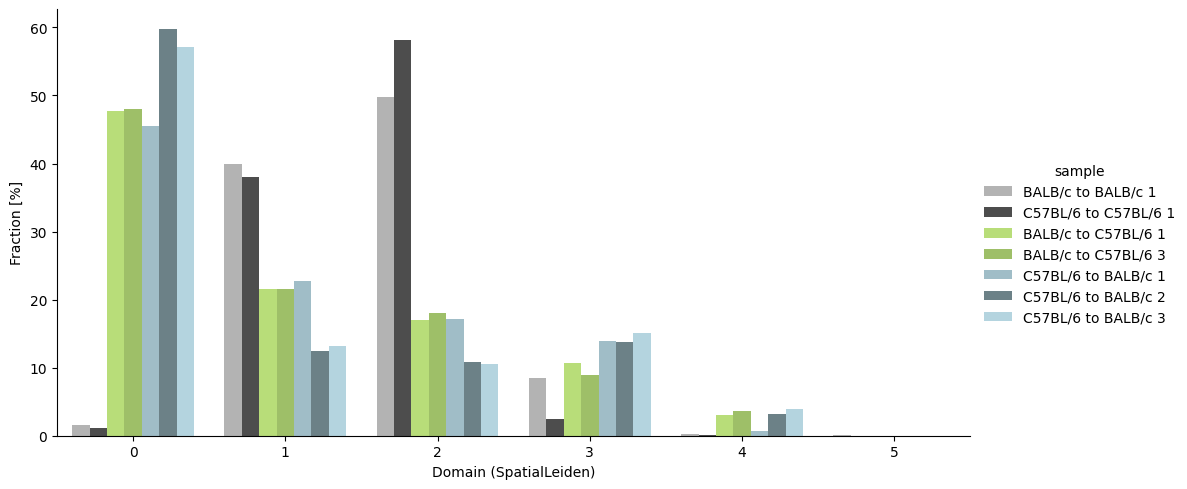

In [30]:
batch = "sample"
anno = key

frac = fraction_of_labels(
    subset.obs[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fg = sns.catplot(
    data=frac.assign(fraction=frac["fraction"] * 100),
    kind="bar",
    x=anno,
    y="fraction",
    hue=batch,
    aspect=2,
    palette=ID_colors,
)
_ = fg.set_ylabels("Fraction [%]")
_ = fg.set_xlabels("Domain (SpatialLeiden)")

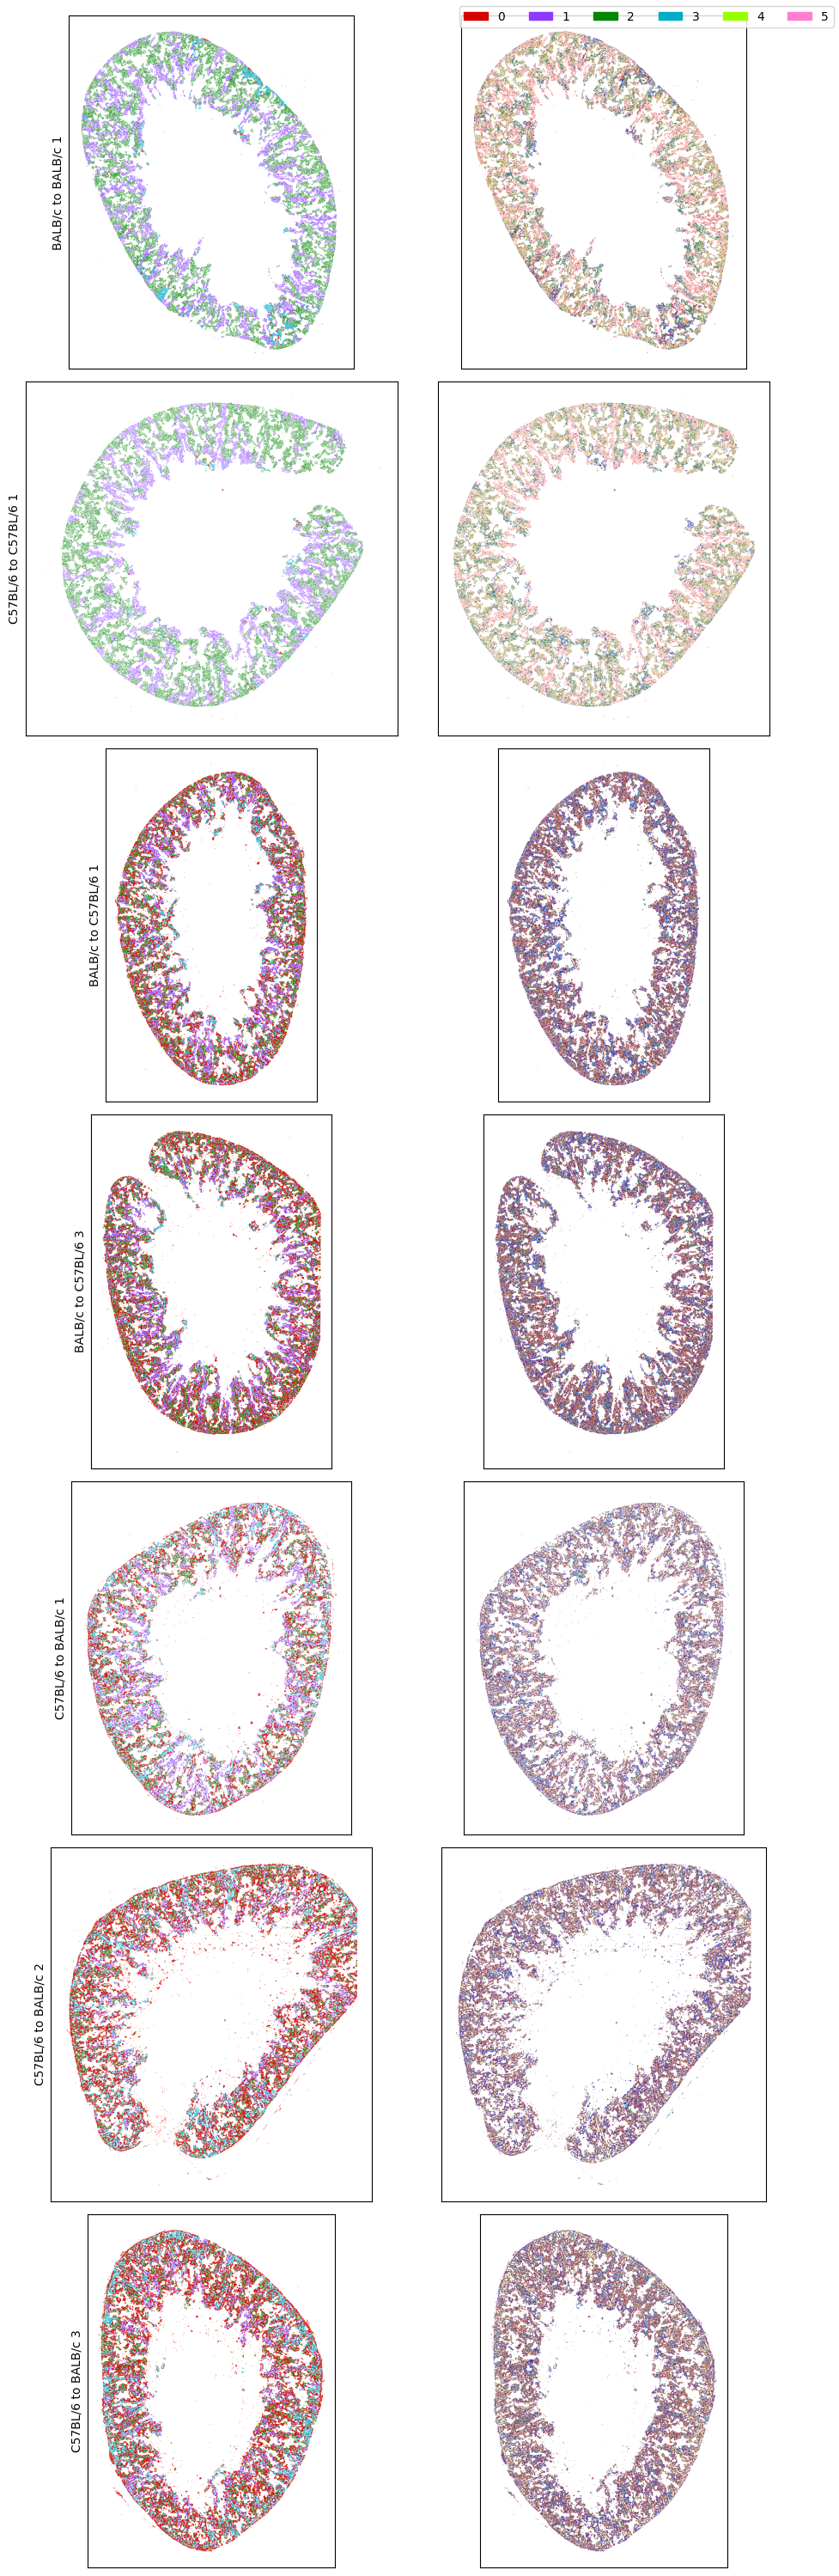

In [28]:
data = subset.obs[["sample", key, "celltype_level_2"]]
data.loc[:, ["x", "y"]] = subset.obsm["spatial"]


from matplotlib.patches import Patch

n_domains = data[key].nunique()

fig, axs = plt.subplots(7, 2, figsize=(10, 30))

scatter_kwargs = dict(x="x", y="y", lw=0, s=0.2, palette=cc.glasbey, legend=False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, (s, df) in enumerate(data.groupby("sample", observed=True)):
        sns.scatterplot(data=df, hue=key, ax=axs[i, 0], **scatter_kwargs)
        sns.scatterplot(data=df, hue="celltype_level_2", ax=axs[i, 1], **scatter_kwargs)
        axs[i, 0].set_ylabel(s)
        axs[i, 1].set_ylabel(None)

for ax in axs.ravel():
    ax.set(aspect="equal", xlabel=None, xticks=[], yticks=[])


fig.legend(
    handles=[Patch(color=c, label=i) for i, c in enumerate(cc.glasbey[:n_domains])],
    ncol=10,
)

fig.tight_layout()

In [29]:
# legend_only
fig = plt.figure(figsize=(10, 2))
fig.legend(
    handles=[Patch(color=c, label=i) for i, c in enumerate(cc.glasbey[:n_domains])],
    ncol=10,
    frameon=False,
    loc="center",
)
fig.savefig("legend_sl_pt.png", dpi=300)
fig.savefig("legend_sl_pt.svg")

<Figure size 1000x200 with 0 Axes>

In [34]:
data = subset.obs[["sample", key, "celltype_level_2"]]
data.loc[:, ["x", "y"]] = subset.obsm["spatial"]

/tmp/ipykernel_787185/1177702579.py:3: UserWarning: The palette list has more values (256) than needed (5), which may not be intended.
  sns.scatterplot(


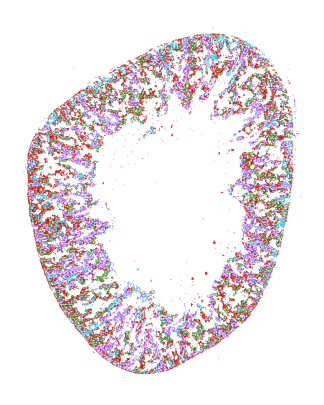

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=data.loc[lambda df: df["sample"] == "C57BL/6 to BALB/c 1"],
    hue=key,
    ax=ax,
    **scatter_kwargs
)
ax.set(aspect="equal", xlabel=None, ylabel=None, xticks=[], yticks=[])
ax.set_axis_off()
fig.savefig("c57bl6_balbc_pt.png", dpi=600)

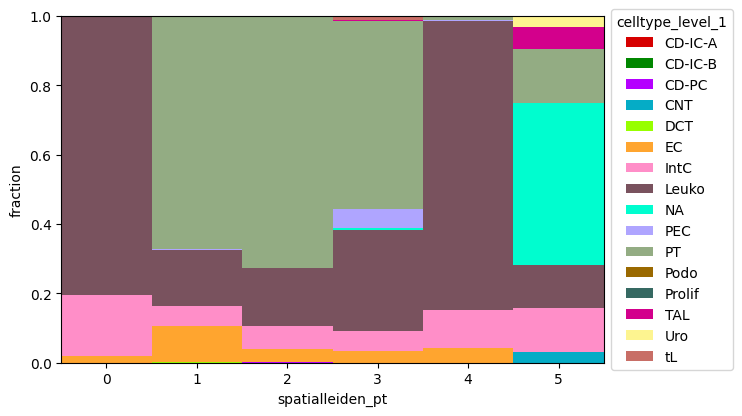

In [32]:
batch = key
anno = "celltype_level_1"

data = subset.obs

frac = fraction_of_labels(
    data[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fig, ax = plt.subplots(figsize=(7, 4.5))
stacked_barplot(
    ax,
    frac,
    batch,
    "fraction",
    hue=anno,
    palette=dict(zip(data[anno].cat.categories, cc.glasbey_light)),
    legend=True,
)

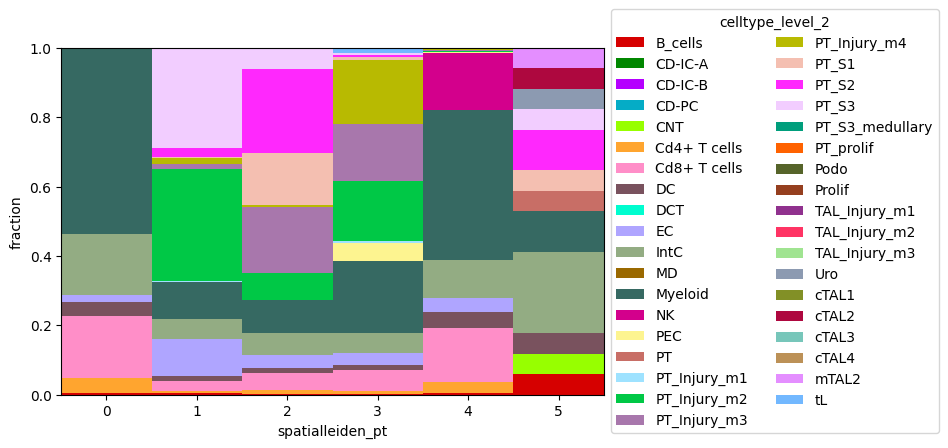

In [33]:
batch = key
anno = "celltype_level_2"

data = subset.obs

frac = fraction_of_labels(
    data[[batch, anno]].assign(**{batch: lambda df: df[batch].cat.as_ordered()}),
    batch,
    anno,
)

fig, ax = plt.subplots(figsize=(7, 4.5))
stacked_barplot(
    ax,
    frac,
    batch,
    "fraction",
    hue=anno,
    palette=dict(zip(data[anno].cat.categories, cc.glasbey_light)),
    legend=True,
)

# Export

In [34]:
from pathlib import Path

import pandas as pd

pd.concat(
    [
        pd.read_table(f, index_col=0).astype(pd.Int8Dtype())
        for f in Path(".").glob("SpatialLeiden*.tsv")
    ],
    axis=1,
).to_csv("SpatialLeiden_combined.tsv.gz", sep="\t")